# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import json, nltk

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

# Functions


### 1. Function: what_post()
- Return rows of `dataframe` that `word` is included in text
____
**Parameters**
- `dataframe`: *dataframe* | dataframe with tweets in 'text' column
- `word`: *list of string* | words to search for

In [2]:
def what_post(dataframe, word):

    if type(word) == str:
        return dataframe[(dataframe['text'].str.contains(word))]
    if type(word) == list:
        return dataframe[dataframe['text'].str.contains('|'.join(word))]

### 2. Function: what_score()
- Return train score, test score, cv score
____
**Parameters**
- `your_model`: *estimator* | estimator that has been fitted to X
- `your_X`: *dataframe* | features
- `your_y`: *series* | target 

In [3]:
def what_score(your_model, your_X, your_y):
    """
    Return train score, test score, cv score
    
    Parameter:
    your_model: estimator
    your X: X
    your y: y
    """
    X_train, X_test, y_train, y_test = train_test_split(your_X,your_y, random_state = 740)
    train_score = your_model.score(X_train, y_train)
    test_score = your_model.score(X_test, y_test)
    cv_score = cross_val_score(your_model, X_train, y_train, cv = 5).mean()
    
    preds = your_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    sens = (tp / (tp+fn))
    spec = (tn / (tn+fp))
    
#     pd.DataFrame({'train': train_score, 'test': test_score, 'cv': cv_score})
    
    out = {'train': train_score, 'test':test_score,
           "cv score": cv_score, "sensitivity": sens,
           "specificity": spec}
    
    return out

### 3. Function: coef_df()
- Return a dataframe with following columns from a gridsearch model with a vectorizer and a logistic regression.
  1. words
  2. coefficient weight (log odd)
  3. exponent of coefficient weight (odd)

---
    
**Parameters**
- `gridsearch_model`: *GridSearch model* | gridSearch model that has been fitted to `X_train` and `y_train`
- `X_train`: *dataframe* | features
- `y_train`: *series* | target
- `vect_str`: *string* | vectorizer name in the `gridsearch_model`
- `reg_str`: *string* | estimator name in the `gridsearch_model`

In [4]:
def coef_df(gridsearch_model, X_train, y_train ,vect_str = 'cvec', reg_str = 'lr' ):

    col_names = gridsearch_model.best_estimator_.named_steps[vect_str].get_feature_names()
    col_coef = gridsearch_model.best_estimator_.named_steps[reg_str].coef_[0]

    cvec_coef_df = pd.DataFrame({
        'words' : col_names,
        'coef' : col_coef,
        'exp_coef': np.exp(col_coef)    
    })
    
    return pd.DataFrame(cvec_coef_df)

### 4. Function: what_important()
- Return a dataframe with following columns from a gridsearch model with a vectorizer and a logistic regression.
  1. words
  2. coefficient weight (log odd)
  3. exponent of coefficient weight (odd)

-----
    
**Parameters**
- `rf_model`: *RandomForestClassifier model* | Your RandomForestClassifier model that has been fitted to `X_rf`
- `X_rf`: *dataframe* | Features for your `rf_model`


In [5]:
def what_important(rf_model, X_rf):

    out = {'features': X_rf.columns,
           'importance': rf_model.feature_importances_}
    return pd.DataFrame(out).sort_values(by = 'importance', ascending = False)

### 5. Function: auc_roc_plot()
- Plot AUC ROC curve

----
    
**Parameters**
- `gridsearch_model`: *GridSearch model* | GridSearch model that has been fitted to `X`_train and `y`_train 
- `X`: *dataframe* | Features
- `y`: *series* | Target 


In [6]:
def auc_roc_plot(gridsearch_model, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
        
    ths = np.linspace(0, 1, 200)
    sens = []
    fp_rate = []
    pred_proba_df = pd.DataFrame(gridsearch_model.predict_proba(X_test))

    # Calculate sensitivity and false positive rate
    for th in ths:
        preds = pred_proba_df.loc[:,[1]].applymap(lambda x: 1 if (x > th) else 0)
         ##https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

        sens.append(tp / (tp+fn))
        fp_rate.append(1 - (tn / (tn+fp)))

    # Plot ROC curve.    
    plt.figure(figsize = (15,5))

    plt.plot(fp_rate, sens, label = 'ROC Curve')

    plt.plot(ths,ths,label='baseline', linestyle='--', color='orange')

    plt.title(f'AUC ROC Score: {round(roc_auc_score(y_test, pred_proba_df.loc[:,[1]]),3)}', fontsize = 25)
    plt.xlabel('False Posive Rate (1 - Specificity)', fontsize = 18)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 15)
    plt.tight_layout() 

# Explore and Clean Data 

In [7]:
# Read data
df = pd.read_csv('../data/train_w_label.csv')

In [8]:
df.head()

,text,hashtags,user_name,date,user_location,label
0,Congrats pre,NaN,MasterAR9012502,2019-10-24 15:05:01+00:00,NaN,0
1,Wassup?,NaN,theprejon,2019-10-21 20:54:33+00:00,NaN,0
2,"Ini mbc korea yang komen orang indo semueh,, b...",NaN,KhoyrR,2019-10-24 14:19:01+00:00,NaN,0
3,Meron pre?,NaN,Zendriccccc,2019-10-26 13:00:29+00:00,NaN,0
4,this is their pre-p3p5 fam love story thanks,NaN,akihikologist,2019-10-21 02:44:47+00:00,NaN,0


In [9]:
df.shape

(2728, 6)

We have 2728 rows and 6 columns.

In [13]:
df.dtypes

text             object
hashtags         object
user_name        object
date             object
user_location    object
label             int64
dtype: object

In [231]:
df.isnull().sum()

text                1
hashtags         1315
user_name           0
date                3
user_location    2726
label               0
dtype: int64

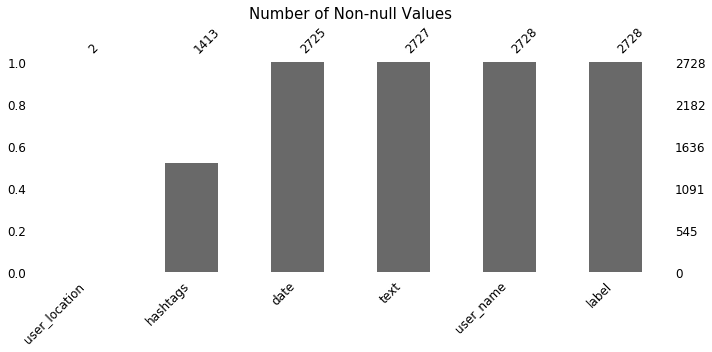

In [232]:
plt.title(label = 'Number of Non-null Values', fontsize = 15)
msno.bar(df, sort = "ascending", figsize= (10,5), fontsize = 12);
plt.tight_layout()

- Among total of 2728 rows, number of rows with non-null values are following.
      - text: 2727
      - hashtags: 1413
      - user_name: 2728
      - date: 2725
      - user_location: 2
      - label: 2728

- About half of observations in 'hashtags' column.
- There is only 2 observations in 'user_locations' column. Therefore, drop user_location column completely since there isn't enough locations available (We could only scrap 2). 

In [233]:
# Using drop funtion and over writing the dataframe. Axis= 1 means we are dropping the column
df = df.drop('user_location', axis = 1)

**Check 'label' column:**
   - 0 represents irrelevant tweets
   - 1 represents relevant tweets
   - 2 represents may be relevent or may not be relevant (ambiguous tweets)

In [234]:
df['label'].value_counts()

0    1840
1     804
2      84
Name: label, dtype: int64

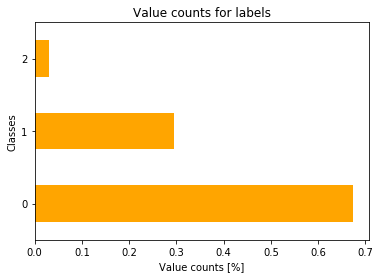

In [235]:
plt.title('Value counts for labels')
df['label'].value_counts(normalize=True).plot(kind = 'barh', color = 'orange');
plt.ylabel('Classes')
plt.xlabel('Value counts [%]');

Class 1 and 2 are about 3 to 7 ratio and the two classes are total of 2644 rows. The size of the data is big enough to build model. As there will be more tweets that are not related to disasters than the ones that are related to disasters, the class ratio of 3 to 7 is good starting point.

In [236]:
# rewriting the dataframe without label = 2
df = df[df['label']!=2]

In [237]:
#checking to make sure label = 2 is dropped
df['label'].value_counts()

0    1840
1     804
Name: label, dtype: int64

**Clean date column**:
Dropped the rows with null dates

In [238]:
df['date'].dropna(inplace=True)

**Clean text column**:
Replace null rows with empty string.

In [239]:
df['text'] = df['text'].fillna("").copy()

# Stop Words

In [271]:
stop_word_list = list(ENGLISH_STOP_WORDS) + ['fire', 'firefighters', 
                                             'twitter', 'pic', 'www', 'http', 'https','massive', 
                                             'wildfire', 'busted', 'burns', 'patch', 'california', 
                                             'utm_campaign','com', 'ho', 'bad', 'new', 'round', '3a', 
                                             'trueanthem', 'content', 'content_utm']

**Check how often stopwords appear in tweets**

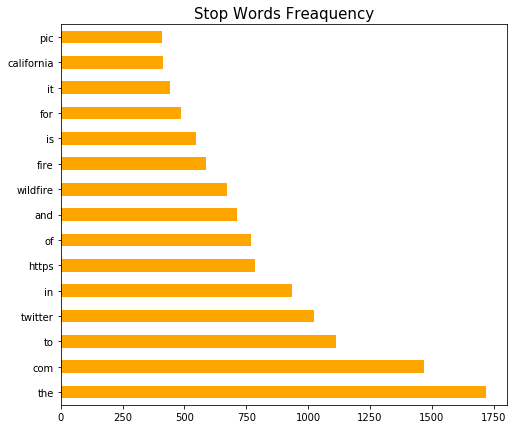

In [241]:
cv = CountVectorizer(ngram_range =(1,1), min_df= 2)
text_ft_sw= cv.fit_transform(df['text'])
text_df_sw= pd.DataFrame(text_ft_sw.toarray(), columns=cv.get_feature_names())

cols_in_stopwords = []
for val in text_df_sw.columns:
    if val in custom_stop:
        cols_in_stopwords.append(val)

text_df_sw[cols_in_stopwords].sum().sort_values(ascending=False).head(15).plot(kind='barh', figsize= (8,7), color = 'orange')
plt.title('Stop Words Freaquency', fontsize = 15);

In [242]:
text_df_sw.shape

(2644, 3782)

15th most frequent stopword appear in about 65 percent of the tweets. This suggests that the stopwords appears in most tweets and are not likely to be important factor in classifying disaster related tweets. More stopwords can to be added or some stopword can be eliminated depends on the model's performance.

---



**Perform a split of our `X` and `y`**

In [243]:
X = df['text']
y = df['label']

X_train,X_test, y_train,y_test = train_test_split(X, y, random_state = 740)

# Modeling

In order to classify tweets as relevant, we aimed to **minimize false negatives (type II error)** and worked to **maximize our sensitivity score**.  False negative values occur when a tweet that is about a disaster is classified as being irrelevant and we did not want to miss any tweets that might matter. 

### 1. Logistic Regression : TF- IDF

**Search for best hyperparameters using Gridsearch**

| Hyperparameter | Description |
| --- | ---|
| **`tfidf__n_gram_range`** | The lower and upper boundary of the range of n-values for different n-grams to be extracted. |
| **`tfidf__max_df`** | When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold  |
| **`tfidf__min_df`** | When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. |
| **`tfidf__analyzer`** | Whether the feature should be made of word or character n-grams. |
| **`tfidf__max_features`** | Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus |

**Build pipeline before Gridsearching**

In [244]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words = custom_stop)),
                 ('logreg', LogisticRegression(solver = 'lbfgs', multi_class = 'auto'))])

In [245]:
pipe_params = {
    'tfidf__ngram_range' :[(1,1)],
    'tfidf__max_df':[.8],
    'tfidf__min_df' :[3,4,5,6,7],
    'tfidf__analyzer': ['word'],
    'tfidf__max_features':[5000, 3000, 2000]}

In [246]:
gs = GridSearchCV(pipe, pipe_params, cv = 5)
gs.fit(X_train, y_train);

**Best Parameters from our Gridsearch**

In [247]:
gs.best_params_

{'tfidf__analyzer': 'word',
 'tfidf__max_df': 0.8,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 7,
 'tfidf__ngram_range': (1, 1)}

**Score from our Gridsearch**

In [248]:
what_score(gs.best_estimator_, X, y)

{'train': 0.8819969742813918,
 'test': 0.8608169440242057,
 'cv score': 0.8315751978220491,
 'sensitivity': 0.6243386243386243,
 'specificity': 0.9555084745762712}

** Check important words in classifying disaster related tweets (coefficient analysis)**

In [249]:
coef_tfidf = coef_df(gs, X_train, y_train ,vect_str = 'tfidf', reg_str = 'logreg' )

In [250]:
coef_tfidf.sort_values(by = 'exp_coef', ascending = False).head(10)

,words,coef,exp_coef
630,winds,3.213300,24.860987
95,canyon,3.192201,24.341944
36,acres,2.843169,17.170100
1,000,2.090911,8.092285
614,view,2.015795,7.506694
361,map,1.945584,6.997716
533,smoke,1.833344,6.254768
48,ana,1.751442,5.762906
112,closed,1.743505,5.717350
416,palisades,1.729469,5.637658


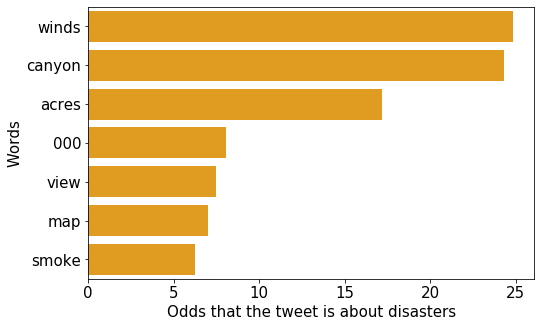

In [251]:
fig = plt.figure(figsize=(8,5))
sns.barplot(y= 'words', x = 'exp_coef',
            data= coef_tfidf.sort_values(by = 'exp_coef', ascending = False).head(7),
            color = 'orange')
plt.xlabel("Odds that the tweet is about disasters", fontsize=15)
plt.ylabel("Words", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

Winds, canyon and acres are among the most import words in classifying disaster realted tweets. The disaster type of the scrapped data is restrained to 'wild fire'. Considering winds are important indicator in understanding where the fire is spreading towards and how fast the fire is spreading.  However, I'm not sure how the words '000', 'view' and 'map' are related to wildfire.

---

**Explore how words '000', 'view' and 'map' are used in disaster related tweets.**

In [252]:
what_post(df, ['000','view','map']).loc[what_post(df, ['000','view','map'])['label'] == 1,:].head()

,text,hashtags,user_name,date,label
915,A Wish To All Of My Family / Friends / Colleag...,NaN,ChrisLevinson,2019-10-27 21:26:57+00:00,1
944,"SoCal’s Tickfire 55 Percent Contained, NoCal’s...",NaN,LightfootInHwd,2019-10-27 13:25:32+00:00,1
945,"SoCal’s Tickfire 55 Percent Contained, NoCal’s...",NaN,Highlighthwd,2019-10-27 13:25:31+00:00,1
950,Large bones that appeared to belong to a decea...,NaN,KTLAMorningNews,2019-10-27 12:32:36+00:00,1
951,Large bones that appeared to belong to a decea...,NaN,KTLA,2019-10-27 12:06:03+00:00,1


- **'000'**: '000' was used in tweets that talked about statistics about fire. (Ex. patrol guy started a 47,000 acre wildfire, Wildfire Has Affected Over 100,000 People & Over 4,000 Acres!)
- **'view'**: 'view' was used in tweets that explained what the user was seeing. (Ex. Stayed at a hotel last night because of #TickFire evacuations. Woke up to this view.., The #KincadeFire view from Petrified Forest Road)
- **'map'**: 'map' was used in tweets that displays map.

**Check the result of the fitting**

In [253]:
what_score(gs.best_estimator_, X, y)

{'train': 0.8819969742813918,
 'test': 0.8608169440242057,
 'cv score': 0.8315751978220491,
 'sensitivity': 0.6243386243386243,
 'specificity': 0.9555084745762712}

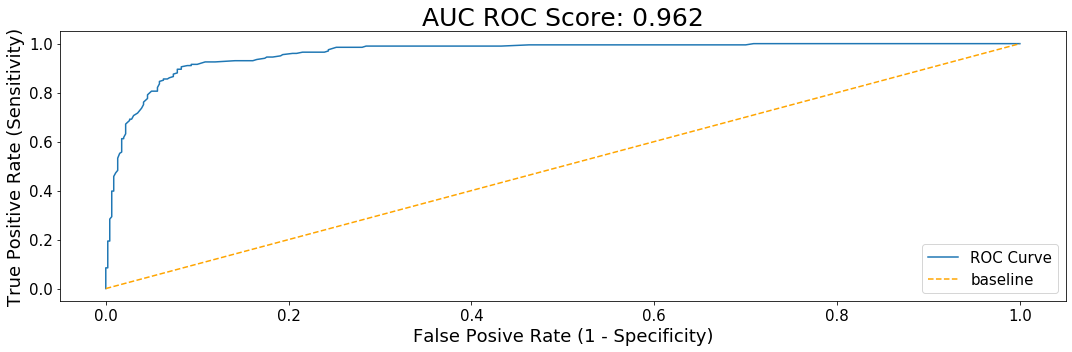

In [254]:
auc_roc_plot(gs, X, y)

### Result (Logistic Regression : TF- IDF)

| Score Type | Scores       |
|-------------------|--------------------|
| Train score    | 0.88 |                                            
| Test score     | 0.86 |                            
| CV score   | 0.83 |
| Sensitivity| 0.62 |
| Specificity| 0.95 | 
| AUC ROC| 0.96 | 

Observations:
- Test score and CV score is higher than Train score. This shows a sign of overfit (high variance)
- Sensitivity is lower than specificity. As we aim to opimize our model on sensitivity, this needs an improvement.

### 2. Random Forest : TF- IDF

**Search for best hyperparameters using Gridsearch**

| Argument | Description| 
| --- | ---|
| **`tfidf__n_gram_range`** | The lower and upper boundary of the range of n-values for different n-grams to be extracted. |
| **`tfidf__max_df`** | When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold  |
| **`tfidf__min_df`** | When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. |
| **`tfidf__analyzer`** | Whether the feature should be made of word or character n-grams. |
| **`tfidf__max_features`** | Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus |
| **`rf__n_estimators`** | The number of trees in the forest. |
| **`rf__max_depth`** | The maximum depth of the tree. |


**Build pipeline before Gridsearching**

In [255]:
pipe_2 = Pipeline([('tfidf', TfidfVectorizer(stop_words = custom_stop)),
                 ('rf', RandomForestClassifier())])


pipe_params_2 = {
    'tfidf__ngram_range' :[(1,1), (1,2)],
    'tfidf__max_df':[.8],
    'tfidf__min_df' :[3,4,5,6,7],
    'tfidf__analyzer': ['word'],
    'tfidf__max_features':[5000, 3000, 2000],
    'rf__n_estimators':[10, 100, 300],
    'rf__max_depth' : [4, 5, 6]}

In [256]:
gs_2 = GridSearchCV(pipe_2, param_grid = pipe_params_2, cv = 5)

In [257]:
gs_2.fit(X_train, y_train);

**Best Parameters from our Gridsearch**

In [258]:
gs_2.best_params_

{'rf__max_depth': 6,
 'rf__n_estimators': 10,
 'tfidf__analyzer': 'word',
 'tfidf__max_df': 0.8,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 6,
 'tfidf__ngram_range': (1, 2)}

**Score from our Gridsearch**

In [259]:
what_score(gs_2.best_estimator_, X, y)

{'train': 0.7725668179525971,
 'test': 0.762481089258699,
 'cv score': 0.760972444851538,
 'sensitivity': 0.21693121693121692,
 'specificity': 0.9809322033898306}

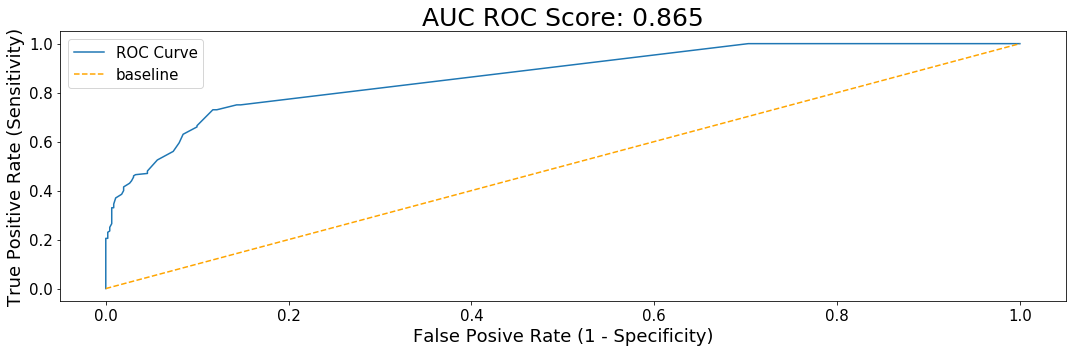

In [260]:
auc_roc_plot(gs_2, X, y)

** Check important words in classifying disaster related tweets**

In [261]:
tfidf = gs_2.best_estimator_.named_steps['tfidf']
tfidf_X = tfidf.fit_transform(X_train)
tfidf_X_df= pd.DataFrame(tfidf_X.toarray(), columns=tfidf.get_feature_names())
imp_rf = what_important(gs_2.best_estimator_.named_steps['rf'], tfidf_X_df)
imp_rf.sort_values(by = 'importance', ascending = False).head(10)

,features,importance
65,acres,0.099774
163,canyon,0.079189
902,winds,0.060192
89,angeles,0.052983
769,sonoma,0.041782
2,000 acres,0.038769
640,pre,0.038659
212,country,0.027582
86,ana,0.023740
861,update,0.020621


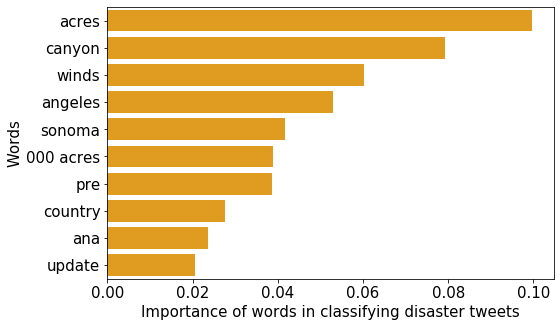

In [262]:
fig = plt.figure(figsize=(8,5))
sns.barplot(y= 'features', x = 'importance',
            data= imp_rf.sort_values(by = 'importance', ascending = False).head(10), color = 'orange')
plt.xlabel("Importance of words in classifying disaster tweets", fontsize=15)
plt.ylabel("Words", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

### Result (Random Forest : TF- IDF)


| Scores   | Results        | 
|------|--------|
| Train score    | 0.77 | 
| Test score     | 0.76 |
| CV score   | 0.76 |
| Sensitivity | 0.22 |
| Specificity | 0.98|
| AUC ROC| 0.87 |


Accuracy scores (train, text, CV scores) are lower than Logistic Regression : TF-IDF model, although overfit was relieved. Furthermore, AUC ROC score of 0.87 shows the sign of inbalance in type 1 error and type 2 errors. This can be confirmed with sensitivity of 0.22 and specificity of 0.98. Most importantly, as we are optimizing for sensitivity, the low sensitivity means the model is poorly performing. 

### 3. Multinomial Naive Bayes: CountVectorizer

**Search for best hyperparameters using Gridsearch**

| Argument | Description |
| --- | ---|
| **`cvec__n_gram_range`** | The lower and upper boundary of the range of n-values for different n-grams to be extracted. |
| **`cvec__max_features`** | build a vocabulary that only consider the top max_features ordered by term frequency across the corpus|


**Build pipeline before Gridsearching**

In [300]:
pipe_3 = Pipeline([
    ("cvec", CountVectorizer(stop_words = stop_word_list)),
    ("nb", MultinomialNB())])

In [306]:
params_3 = {
    "cvec__ngram_range": [(1,1), (2,2)],
    "cvec__max_features": [9000, 12000]}

In [307]:
gs_3 = GridSearchCV(pipe_3, params_3, cv=5)

In [308]:
gs_3.fit(X_train, y_train);

**Best Parameters from our Gridsearch**

In [309]:
gs_3.best_params_

{'cvec__max_features': 9000, 'cvec__ngram_range': (1, 1)}

**Score from our Gridsearch**

In [310]:
what_score(gs_3, X, y)

{'train': 0.9409984871406959,
 'test': 0.8411497730711044,
 'cv score': 0.8209665928809506,
 'sensitivity': 0.8994708994708994,
 'specificity': 0.8177966101694916}

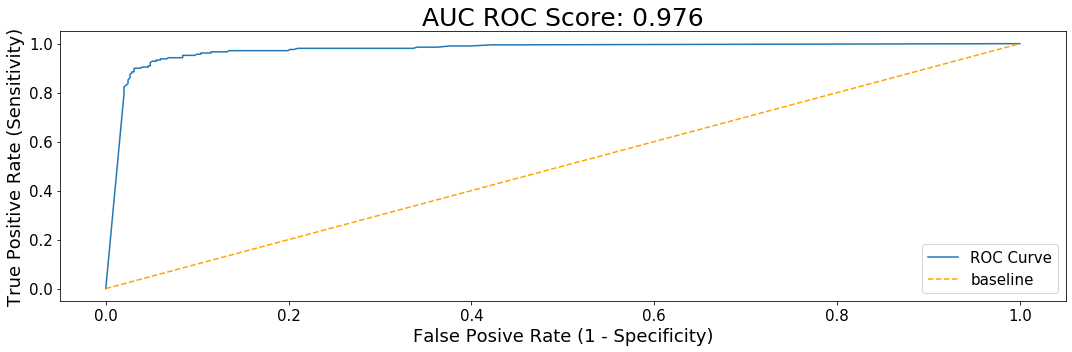

In [311]:
auc_roc_plot(gs_3, X, y)

### Result (Multinomial Naive Bayes: CountVectorizer)

Since the scores are better than the logistic regression model, we will go with Multinomial Naive Bayes Model

| Scores              | Results             |
|-------------------|--------------------|
| Train score    | 0.94 | 
| Test score     | 0.84 | 
| Cross val score   | 0.82 | 
| Sensitivity| 0.90 | 
| Specificity| 0.82| 
| AUC ROC | 0.97 | 


Observations:

- Although the accuracy scores have imporved from Random Forest : TF- IDF, this model shows a stronger sign of overfitting than Random Forest : TF- IDF as well as Logistic Regression : TF - IDF. 
- This model has the best AUC ROC score than the two previous models, which shows that there is a good balance of type 1 and type 2 errors. Most importantly, it has high sensitivity.

# Conclusion
**Multinomial Naive Bayes/CVEC models was selected to be the final model.**

|                  |Logistic Regression/TF-IDF  | Random Forest/TF-IDF  | Multinomial Naive Bayes/CVEC  |
|------------------|---------------------|---------------|-------------------------|
| Training score   | 0.88              | 0.77        | 0.94                  |
| Testing score    | 0.86              | 0.76        | 0.84                |
| CV score         | 0.83              | 0.76        | 0.82                  |
| Sensitivity      | 0.62              | 0.22        | 0.90                  |
| Specificity      | 0.95              | 0.98        | 0.82                  |
| ROC AUC score    | 0.96               | 0.87         | 0.98                  |

Multinomial Naive Bayes/CVEC model shows high accuracy score with good balance of Type 1 error and Type 2 errors. Most importantly, as we aim to minimize type 2 error, high sensitivity of the Multinomial Naive Bayes/CVEC model indicates that this model is a big advantage.